In [1]:
import torch
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import time
import os
import copy
import torch.optim as optim


# load pretrained network

In [22]:
# load different models already pretrained from imagenet

alexnet = models.alexnet(weights="IMAGENET1K_V1")
efficientnet = models.efficientnet_b7(weights="IMAGENET1K_V1")
vgg_19 = models.vgg19(weights='IMAGENET1K_V1')
# inception_v3 = models.inception_v3(weights="IMAGENET1K_V1") # size of input 299 * 299 instead of 224 * 224
resnet = models.resnet50(weights="IMAGENET1K_V2")

selected_models = {'resnet': resnet, 'alexnet': alexnet, 'efficientnet_b7':efficientnet, 'vgg_19':vgg_19}


modify the last layer of those networks to a fully connected layer with only 15 outputs ( for our 15 classes)

In [23]:
print(f"before modification : {selected_models['resnet'].fc}")
for key in selected_models.keys():
    model = selected_models[key]
    # set the learning of all the previous layers to false 
    # (already extracting the image features from their previous training)
    for param in selected_models[key].parameters():
        param.requires_grad = False
    
    # get last_layer size to fully connect our last decision layer
    last_layer = [key for key in model.state_dict().keys()][-2]
    last_layer_size = model.state_dict()[last_layer].shape[-1]
    try:
        selected_models[key].classifier = nn.Sequential(*list(model.classifier)[:-1], nn.Linear(last_layer_size, 15))
    except Exception:
        selected_models[key].fc = nn.Linear(last_layer_size, 15)

print(f"after modification : {selected_models['resnet'].fc}")

before modification : Linear(in_features=2048, out_features=1000, bias=True)
after modification : Linear(in_features=2048, out_features=15, bias=True)


In [24]:
class_names = {
    0: 'badminton',
    1: 'baseball',
    2: 'basketball',
    3: 'boxing',
    4: 'cricket',
    5: 'football',
    6: 'gymnastics',
    7: 'hockey',
    8: 'swimming',
    9: 'table_tennis',
    10: 'tennis',
    11: 'volleyball',
    12: 'weight_lifting',
    13: 'wrestling',
    14: 'wwe'
}

transform images into tensor to input them into the convolutional networks

In [25]:
preprocess_image = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])
])

transform every image to make a dataset of tensor

In [26]:
df = pd.read_csv("./data/data.csv") # path to images
y = torch.as_tensor(df['label'].values)
image_paths = df['path']
images = []

for path in image_paths:
    try:
        img = Image.open(path)
        images.append(preprocess_image(img.convert('RGB')))
    except Exception as e:
        pass

X = torch.stack(images)
print(X.shape)

torch.Size([10303, 3, 224, 224])


prepare the batch function to separate training data into batch of a certain size

In [7]:
def get_batch(X, y, batch_size, iteration):
    start = batch_size * iteration
    end = (batch_size) * (iteration + 1)
    if end > X.shape[0]:
        end = X.shape[0]
    return X[start:end, :, :, :], y[start:end]

batch_x, batch_y = get_batch(X, y, 50, 0)
print(batch_x.shape, batch_y.shape)


torch.Size([50, 3, 224, 224]) torch.Size([50])


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Split datasets into training and testing set

In [9]:
from sklearn.model_selection import train_test_split

def train_val_dataset(X, y, testing_size=0.25):
    train_idx, test_idx = train_test_split(list(range(X.shape[0])), test_size=testing_size)
    datasets = {}
    datasets['X_train'] = X[train_idx,:,:,:]
    datasets['X_test'] = X[test_idx,:,:,:]
    datasets['y_train'] = y[train_idx]
    datasets['y_test'] = y[test_idx]

    return datasets

datasets = train_val_dataset(X, y, 0.25)
print(datasets['X_train'].shape)

torch.Size([7727, 3, 224, 224])


In [10]:
def train_model(datasets, model, criterion, optimizer, batch_size = 100, num_epochs=5):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    accuracies = {}

    X_train, y_train, X_test, y_test = datasets['X_train'], datasets['y_train'], datasets['X_test'], datasets['y_test']

    batch_train_count = (X_train.shape[0] // batch_size) + 1
    batch_test_size = batch_size * 2
    batch_test_count = (X_test.shape[0] // batch_test_size) + 1

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        # training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for num_batch in range(batch_train_count):
            if (num_batch % 15 == 0):
                print(f'batch train : {num_batch}/{batch_train_count}')
            inputs, labels = get_batch(X_train, y_train, batch_size, num_batch)
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels.long())
                # backward + optimize
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)
        
        epoch_train_loss = running_loss / datasets[f'X_train'].shape[0]
        epoch_train_acc = running_corrects / datasets[f'X_train'].shape[0]

        # testing set
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        for num_batch in range(batch_test_count):
            if (num_batch % 5 == 0):
                print(f'batch test : {num_batch}/{batch_test_count}')
            inputs, labels = get_batch(X_test, y_test, batch_test_size, num_batch)
            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels.long())
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)

        epoch_test_loss = running_loss / datasets[f'X_test'].shape[0]
        epoch_test_acc = running_corrects / datasets[f'X_test'].shape[0]

        accuracies[epoch] = {'train accuracy' : epoch_train_acc.item(), 
                            'test accuracy' : epoch_test_acc.item(),
                            'train loss': epoch_train_loss,
                            'test loss': epoch_test_loss}

        # deep copy the model if better
        if epoch_test_acc > best_acc:
            best_acc = epoch_test_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, accuracies

In [11]:
def imshow(inp, axis):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    axis.imshow(inp)

def visualize_model(X, y, model, num_images=12, suptitle=None):
    "display several images predictions and truth for all of them"
    nb_row = num_images // 4 if num_images % 4 == 0 else (num_images // 4) + 1
    fig, ax = plt.subplots(nb_row, 4, sharex='col', sharey='row', figsize=(10, 10*(nb_row/4)))
    plt.subplots_adjust(hspace=0.5)

    if suptitle is not None:
        fig.suptitle(suptitle, fontsize = 16)

    with torch.no_grad():
        inputs, labels = X, y
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        _, class_number = torch.max(labels, 1)

        for row_index in range(num_images):
            imshow(inputs[row_index], ax[row_index//4, row_index % 4])
            ax[row_index//4, row_index % 4].axis('off')
            title = f'predicted: {class_names[preds[row_index].item()]}\ntruth: {class_names[class_number[row_index].item()]}'
            ax[row_index//4, row_index % 4].set_title(title)

Train all the models with 5 epochs 

In [12]:
criterion = nn.CrossEntropyLoss()
opti_models = {}
model_accuracies = {}

for model_name, model in selected_models.items():
    if model_name != 'resnet':
        print(model_name)
        optimizer_ft = optim.Adam(model.parameters(), lr=0.01)
        model = model.to(device)
        model_opti, model_accuracy = train_model(datasets, model, criterion, optimizer_ft, batch_size=150, num_epochs=5)
        model_scripted = torch.jit.script(model_opti) # Export to TorchScript
        opti_models[model_name] = model_opti
        model_accuracies[model_name] = model_accuracy
        model_scripted.save(f'./models/{model_name}.pt') # Save



resnet
Epoch 0/4
batch train : 0/52
batch train : 15/52
batch train : 30/52
batch train : 45/52
batch test : 0/9
batch test : 5/9
Epoch 1/4
batch train : 0/52
batch train : 15/52
batch train : 30/52
batch train : 45/52
batch test : 0/9
batch test : 5/9
Epoch 2/4
batch train : 0/52
batch train : 15/52
batch train : 30/52
batch train : 45/52
batch test : 0/9
batch test : 5/9
Epoch 3/4
batch train : 0/52
batch train : 15/52
batch train : 30/52
batch train : 45/52
batch test : 0/9
batch test : 5/9
Epoch 4/4
batch train : 0/52
batch train : 15/52
batch train : 30/52
batch train : 45/52
batch test : 0/9
batch test : 5/9
Training complete in 131m 26s
Best val Acc: 0.884317
inception_v3
Epoch 0/4
batch train : 0/52


RuntimeError: Calculated padded input size per channel: (3 x 3). Kernel size: (5 x 5). Kernel size can't be greater than actual input size

In [17]:
to_write = {'resnet': {0: {'train accuracy': 0.7748, 'test accuracy': 0.8696, 'train loss': 0.7816347050083645, 'test loss': 0.4368424338305959}, 1: {'train accuracy': 0.9410, 'test accuracy': 0.8808, 'train loss': 0.24453126629774732, 'test loss': 0.4011834742304701}, 2: {'train accuracy': 0.9749, 'test accuracy': 0.8800, 'train loss': 0.14043530557987777, 'test loss': 0.39463841868853716}, 3: {'train accuracy': 0.9908, 'test accuracy': 0.8835, 'train loss': 0.08927861134524917, 'test loss': 0.3893638677108362}, 4: {'train accuracy': 0.9952, 'test accuracy': 0.8843, 'train loss': 0.06367231830588145, 'test loss': 0.3908182827767378}}}

{0: {'train accuracy': tensor(0.7748), 'test accuracy': tensor(0.8696), 'train loss': 0.7816347050083645, 'test loss': 0.4368424338305959}, 1: {'train accuracy': tensor(0.9410), 'test accuracy': tensor(0.8808), 'train loss': 0.24453126629774732, 'test loss': 0.4011834742304701}, 2: {'train accuracy': tensor(0.9749), 'test accuracy': tensor(0.8800), 'train loss': 0.14043530557987777, 'test loss': 0.39463841868853716}, 3: {'train accuracy': tensor(0.9908), 'test accuracy': tensor(0.8835), 'train loss': 0.08927861134524917, 'test loss': 0.3893638677108362}, 4: {'train accuracy': tensor(0.9952), 'test accuracy': tensor(0.8843), 'train loss': 0.06367231830588145, 'test loss': 0.3908182827767378}, 'resnet': {...}}


In [19]:
import json
with open('resnet_accuracies.txt', 'w') as f:
    f.write(json.dumps(to_write))

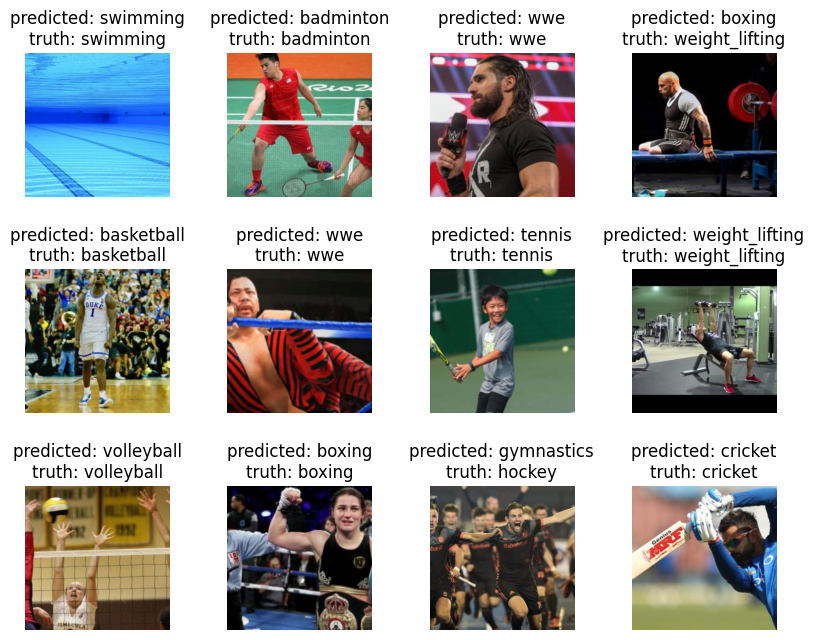

In [ ]:

fig, ax = plt.subplots(2, len(model_accuracies), sharex='col', sharey='row', figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

for index, (model_name, model_accuracies) in enumerate(model_accuracies.items()):
    ax[0, index].plot([key for key in model_accuracies.keys()], [value['test accuracy'] for value in model_accuracies.values()])
    ax[0, index].title(model_name)
    ax[0, index].xlabel('epochs')
    ax[0, index].ylabel('accuracies')

    ax[1, index].plot([key for key in model_accuracies.keys()], [value['test loss'] for value in model_accuracies.values()])
    ax[1, index].title(model_name)
    ax[1, index].xlabel('epochs')
    ax[1, index].ylabel('accuracies')

In [ ]:
idx = np.random.choice(range(X.shape[0]), replace=False, size=12)
for model_name, opti_model in opti_models.items():

    # model_opti = torch.jit.load('./models/alexnet.pt')
    visualize_model(X[idx], y[idx], opti_model, num_images=12, suptitle=f'model : {model_name}')
